# 1.导包

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# 2.读取数据

In [8]:
# 加载数据
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
train_data = train_data.iloc[:-3] # 删除最后三行NaN值

# 3.数据预处理

In [9]:
# 数值特征
numerical_features_to_scale = ['casual', 'registered']  # 需要归一化的特征
numerical_features_no_scale = ['temp', 'atemp', 'hum', 'windspeed']  # 不需要归一化的特征
target_column = 'cnt'

# 数据预处理
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

# 初始化归一化器
scaler_cnt = MinMaxScaler()
scaler_features = MinMaxScaler()

# 归一化目标变量
scaler_cnt.fit(train_data[[target_column]])
train_data[target_column] = scaler_cnt.transform(train_data[[target_column]])
test_data[target_column] = scaler_cnt.transform(test_data[[target_column]])

# 归一化特征
scaler_features.fit(train_data[numerical_features_to_scale])
train_data[numerical_features_to_scale] = scaler_features.transform(train_data[numerical_features_to_scale])
test_data[numerical_features_to_scale] = scaler_features.transform(test_data[numerical_features_to_scale])

In [10]:
# 时间特征处理
def preprocess_time_features(data):
    data['hour_sin'] = np.sin(2 * np.pi * data['hr'] / 24.0)
    data['hour_cos'] = np.cos(2 * np.pi * data['hr'] / 24.0)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7.0)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7.0)
    data['season_sin'] = np.sin(2 * np.pi * data['season'] / 4.0)
    data['season_cos'] = np.cos(2 * np.pi * data['season'] / 4.0)
    data['month_sin'] = np.sin(2 * np.pi * data['mnth'] / 12.0)
    data['month_cos'] = np.cos(2 * np.pi * data['mnth'] / 12.0)
    return data
train_data = preprocess_time_features(train_data)
test_data = preprocess_time_features(test_data)

# 4.特征提取

In [11]:
# 特征列表
features = [
    'hour_sin', 'hour_cos',  # 小时周期
    'weekday_sin', 'weekday_cos',  # 周周期
    'season_sin', 'season_cos',  # 季节周期
    'month_sin', 'month_cos',  # 月份周期
    'yr', 'holiday', 'workingday', 'weathersit',  # 分类特征
    'temp', 'atemp', 'hum', 'windspeed',  # 数值特征
    'casual', 'registered'  # 归一化特征
]

X_train = train_data[features]
X_test = test_data[features]

y_train = train_data[target_column]
y_test = test_data[target_column]

# 5.划分数据集

In [12]:
# 构造时间序列数据（滑动窗口）
def create_dataset(X, y, seq_len=96, output_len=240, step=1):
    features, targets = [], []
    for i in range(0, len(X) - seq_len - output_len + 1, step):
        features.append(X.iloc[i:i+seq_len].values)
        targets.append(y.iloc[i+seq_len:i+seq_len+output_len].values)
    return np.array(features), np.array(targets)

train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=96, output_len=240)
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=96, output_len=240)

In [13]:
# 自定义数据集
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(CustomDataset(train_dataset, train_labels), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomDataset(test_dataset, test_labels), batch_size=64, shuffle=False)

# 6. 模型架构

In [14]:
class MultiScaleAttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_heads=8, num_layers=4, output_size=240, dropout=0.3):
        super(MultiScaleAttentionLSTM, self).__init__()
        # 确保卷积层输出特征维度与 hidden_size 一致
        self.conv1 = nn.Conv1d(input_size, hidden_size // 3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_size, hidden_size // 3, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(input_size, hidden_size - 2 * (hidden_size // 3), kernel_size=7, padding=3)

        # 交叉注意力机制
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=dropout)

        # 双向LSTM
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=dropout)

        # 全连接层
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # 多尺度特征提取
        x = x.permute(0, 2, 1)  # [batch_size, input_size, seq_len]
        conv1_out = self.conv1(x)  # [batch_size, hidden_size // 3, seq_len]
        conv2_out = self.conv2(x)  # [batch_size, hidden_size // 3, seq_len]
        conv3_out = self.conv3(x)  # [batch_size, hidden_size - 2 * (hidden_size // 3), seq_len]
        x = torch.cat([conv1_out, conv2_out, conv3_out], dim=1)  # [batch_size, hidden_size, seq_len]
        x = x.permute(2, 0, 1)  # [seq_len, batch_size, hidden_size]

        # 交叉注意力机制
        attn_out, _ = self.attention(x, x, x)
        attn_out = attn_out.permute(1, 0, 2)  # [batch_size, seq_len, hidden_size]

        # 双向LSTM
        lstm_out, _ = self.lstm(attn_out)

        # 全连接层输出
        output = self.fc(lstm_out[:, -1, :])  # 仅保留最后一个时间步的输出
        return output

# 7.训练并保存最佳模型

In [15]:
# 定义多次实验函数
def run_experiments_multiscale_lstm(model_class, train_loader, test_loader, input_size, epochs=50, num_experiments=5):
    """
    运行多次实验，并保存每次实验的最佳模型。
    
    :param model_class: 模型类
    :param train_loader: 训练数据加载器
    :param test_loader: 测试数据加载器
    :param input_size: 输入大小
    :param epochs: 每次实验的训练轮数
    :param num_experiments: 实验次数
    """
    test_losses = []  # 保存每次实验的最佳测试损失

    for i in range(num_experiments):
        print(f"Starting Experiment {i + 1}/{num_experiments}")

        # 初始化模型、优化器和调度器
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model_class(input_size=input_size, hidden_size=256, num_heads=8, num_layers=4, output_size=240).to(device)

        criterion = nn.SmoothL1Loss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)

        best_loss = float('inf')  # 当前实验的最佳测试损失

        for epoch in range(epochs):
            # 训练阶段
            model.train()
            train_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            # 测试阶段
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
            test_loss /= len(test_loader)

            scheduler.step()

            print(f"Experiment {i + 1}, Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            # 保存最佳模型
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), f"model/multiscale_attention_lstm_long_model_{i + 1}.pth")
                print(f"Experiment {i + 1}: Best model saved with Test Loss: {test_loss:.4f}")

        test_losses.append(best_loss)

    # 打印实验结果
    avg_loss = sum(test_losses) / num_experiments
    std_loss = np.std(test_losses)
    print("\nAll Experiments Completed!")
    print(f"Test Losses: {test_losses}")
    print(f"Average Test Loss: {avg_loss:.4f}")
    print(f"Standard Deviation of Test Loss: {std_loss:.4f}")


# 调用多次实验函数
run_experiments_multiscale_lstm(
    model_class=MultiScaleAttentionLSTM,  # 替换为具体的模型类
    train_loader=train_loader,
    test_loader=test_loader,
    input_size=train_dataset.shape[2],  # 替换为输入的实际维度
    epochs=30,
    num_experiments=5
)


Starting Experiment 1/5
Experiment 1, Epoch 1/30, Train Loss: 0.0148, Test Loss: 0.0204
Experiment 1: Best model saved with Test Loss: 0.0204
Experiment 1, Epoch 2/30, Train Loss: 0.0123, Test Loss: 0.0145
Experiment 1: Best model saved with Test Loss: 0.0145
Experiment 1, Epoch 3/30, Train Loss: 0.0058, Test Loss: 0.0195
Experiment 1, Epoch 4/30, Train Loss: 0.0049, Test Loss: 0.0130
Experiment 1: Best model saved with Test Loss: 0.0130
Experiment 1, Epoch 5/30, Train Loss: 0.0041, Test Loss: 0.0112
Experiment 1: Best model saved with Test Loss: 0.0112
Experiment 1, Epoch 6/30, Train Loss: 0.0031, Test Loss: 0.0101
Experiment 1: Best model saved with Test Loss: 0.0101
Experiment 1, Epoch 7/30, Train Loss: 0.0027, Test Loss: 0.0105
Experiment 1, Epoch 8/30, Train Loss: 0.0024, Test Loss: 0.0097
Experiment 1: Best model saved with Test Loss: 0.0097
Experiment 1, Epoch 9/30, Train Loss: 0.0022, Test Loss: 0.0097
Experiment 1: Best model saved with Test Loss: 0.0097
Experiment 1, Epoch 10

# 8. 通过模型进行预测

In [17]:
def predict_average(models, model_class, input_size, hidden_size, num_heads, num_layers, output_size, test_loader):
    """
    使用多个模型进行预测并求平均值。

    :param models: 模型文件路径列表
    :param model_class: 模型类
    :param input_size: 模型输入大小
    :param hidden_size: 隐藏层大小
    :param num_heads: 多头注意力头数
    :param num_layers: Transformer层数
    :param output_size: 模型输出大小
    :param test_loader: 测试数据加载器
    :return: 平均预测结果和真实值
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_predictions = []

    # 遍历所有模型，逐个加载并进行预测
    for model_path in models:
        print(f"Loading model: {model_path}")
        
        # 初始化模型
        model = model_class(
            input_size=input_size,
            hidden_size=hidden_size,
            num_heads=num_heads,
            num_layers=num_layers,
            output_size=output_size
        ).to(device)
        
        model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
        model.eval()

        predictions = []
        actuals = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                # 获取预测值
                outputs = model(batch_X).cpu().numpy()  # 移除 tgt 参数
                predictions.extend(outputs)
                actuals.extend(batch_y.cpu().numpy())

        all_predictions.append(np.array(predictions))  # 将预测结果存储

    # 将所有预测结果求平均
    average_predictions = np.mean(all_predictions, axis=0)  # 逐样本求平均
    return average_predictions, np.array(actuals)

# 定义模型文件路径列表
models = [f"model/multiscale_attention_lstm_long_model_{i+1}.pth" for i in range(5)]

# 调用函数进行预测
average_predictions, actuals = predict_average(
    models=models,
    model_class=MultiScaleAttentionLSTM,  # 替换为你的模型类
    input_size=train_dataset.shape[2],  # 替换为你的输入大小
    hidden_size=256,
    num_heads=8,
    num_layers=4,
    output_size=240,  # 替换为你的输出大小
    test_loader=test_loader
)

# 打印结果
print("Predictions shape:", average_predictions.shape)
print("Actuals shape:", actuals.shape)


Loading model: model/multiscale_attention_lstm_long_model_1.pth


/tmp/ipykernel_8395/3695269197.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重


Loading model: model/multiscale_attention_lstm_long_model_2.pth
Loading model: model/multiscale_attention_lstm_long_model_3.pth
Loading model: model/multiscale_attention_lstm_long_model_4.pth
Loading model: model/multiscale_attention_lstm_long_model_5.pth
Predictions shape: (1825, 240)
Actuals shape: (1825, 240)


# 9.计算MSE和MAE

In [18]:
# 反归一化预测和实际值
average_predictions = scaler_cnt.inverse_transform(average_predictions)
actuals = scaler_cnt.inverse_transform(actuals)

# 每个样本的 MSE 和 MAE
mse_per_sample = np.mean((average_predictions - actuals) ** 2, axis=1)  # 每个样本的 MSE
mae_per_sample = np.mean(np.abs(average_predictions - actuals), axis=1)  # 每个样本的 MAE

# 计算均值和标准差
mse_mean = np.mean(mse_per_sample)
mse_std = np.std(mse_per_sample)
mae_mean = np.mean(mae_per_sample)
mae_std = np.std(mae_per_sample)

# 输出结果
print(f"Mean Squared Error (MSE): {mse_mean:.6f} ± {mse_std:.6f}")
print(f"Mean Absolute Error (MAE): {mae_mean:.6f} ± {mae_std:.6f}")


Mean Squared Error (MSE): 17347.062500 ± 20952.066406
Mean Absolute Error (MAE): 79.703751 ± 46.890667


# 10.绘图

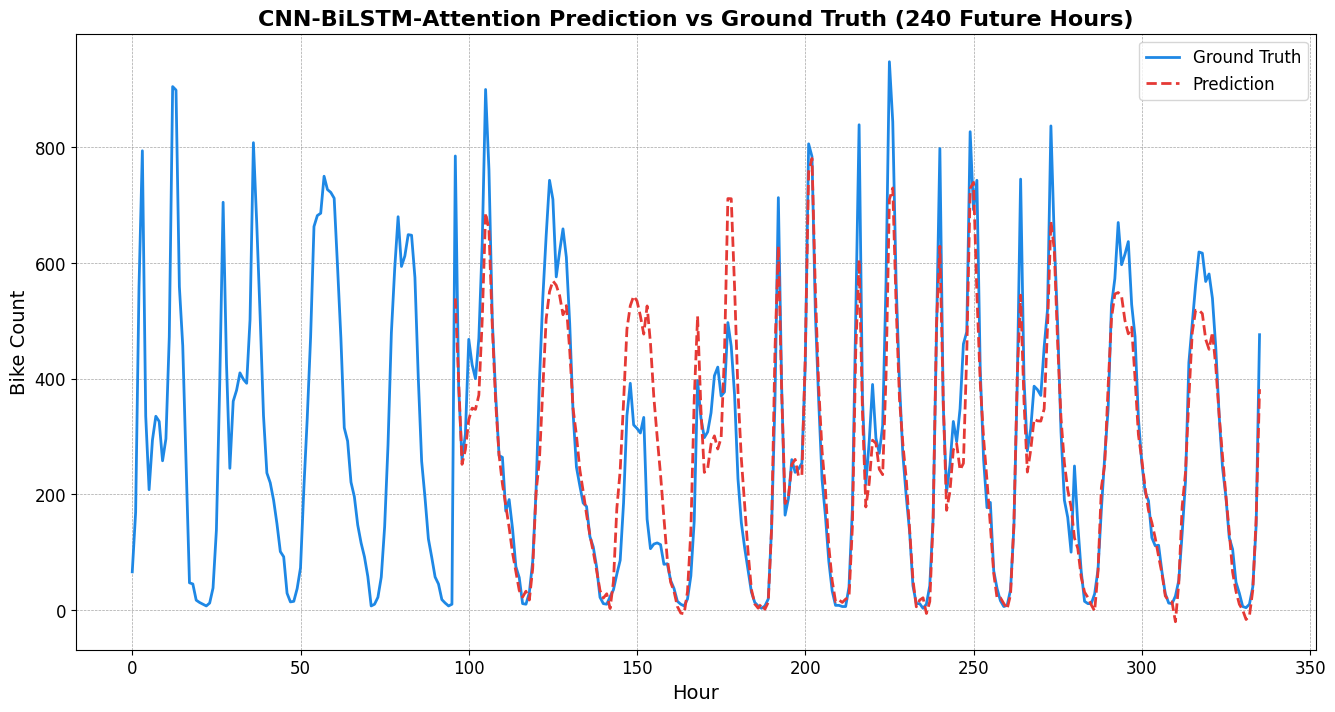

In [20]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# 构造完整数据：过去96小时的真实值和未来240小时的预测值
past_96_hours = scaler_cnt.inverse_transform(y_train.iloc[-96:].values.reshape(-1, 1)).flatten()
future_240_hours_actuals = actuals[0]  # 真实值
future_240_hours_predictions = average_predictions[0]  # 预测值

# 绘制图表
plt.figure(figsize=(16, 8))  # 调整图表大小

# 绘制真实值曲线（过去96小时和未来240小时）
plt.plot(
    range(336),  # 96 + 240 = 336小时
    np.concatenate((past_96_hours, future_240_hours_actuals)), 
    label="Ground Truth", color="#1E88E5", linewidth=2  # 深蓝色
)

# 绘制预测值曲线（未来240小时）
plt.plot(
    range(96, 336),  # 从96到336（仅预测部分）
    future_240_hours_predictions, 
    label="Prediction", color="#E53935", linestyle="--", linewidth=2  # 深红色
)

# 添加图例和标题
plt.legend(fontsize=12, loc="upper right")  # 图例在右上角
plt.title("CNN-BiLSTM-Attention Prediction vs Ground Truth (240 Future Hours)", fontsize=16, fontweight="bold")
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Bike Count", fontsize=14)

# 调整坐标轴样式
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# 保存并展示图像
plt.savefig("cnn_bilstm_attention_bike_rental_predictions_240.png", dpi=300, bbox_inches='tight')
plt.show()
